# Imports

In [1]:
from utils import *

In [2]:
def Dz_from_Da(a):
    z =  - a * sin(deg2rad(angle_incidence)) / sin(deg2rad(data.opt[2]))
    return z * channel_distance


def Dz_from_Ds(s):
    z = s * sin(deg2rad(angle_incidence)) / cos(deg2rad(data.opt[2]))
    return z * channel_distance

# Define paths and parameters

In [3]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/MunchMuseum/M491/'
path_xrd = path_scan + 'ProfiloXRD/'          # XRD scan 
path_xrf = path_scan + 'ProfiloXRF/labels/'   # XRF scan
path_photo = path_scan + 'ProfiloFoto/'       # photo of the scanned section
path_zmap = path_shared + 'VenereBZPosition/'
path_database = path_shared + 'Database/'     # tabulated phases

### Output ###
subfolder_output = 'MunchMuseum/M491/Profilo/'
path_figures = 'figures/' + subfolder_output          # figures generated by the script
path_results = 'results/' + subfolder_output          # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

### Parameters ###
min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # sigma used in the peaks of synthetic diffraction patterns

### Experimental setting ###
angle_incidence = 10.5 # angle between the incident beam and the plane of the painting
channel_distance = 50 # distance in microns between two adjacent channels of the detector

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [4]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    if isdir(path_figures):
        rmtree(path_figures)
    if isdir(path_results):
        rmtree(path_results)
    if isdir(path_database_exp):
        rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [5]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [6]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)
    
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 367


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [7]:
qtl = 0.999

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [8]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [1]) # choose the axes to flip
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Correct burnt pixels and wrong scale in each XRF map
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [9]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1))[newaxis, newaxis, :]
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

data_xrf.labels -= data_xrf.labels.min(axis = (0, 1), keepdims = True)

17 pixels out of 16150 were corrected on average in each XRF map.


# Define phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [10]:
#rename_phase_in_database(database, 'Pb2 Sn O4', 'Lead-tin yellow')

In [11]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]

# Search for primary phases

### Adjust initial calibration
This can be executed after the first fit finds a better initial calibration.

In [12]:
if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])
opt_initial = data.opt.copy()

### Create data structure

In [13]:
phases_primary = [hydrocerussite, lazurite, cinnabar]

In [14]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [15]:
%%time
gm = gm.search()
L1loss, MSEloss, overlap_area = gm.metrics()

Using 8 CPUs
Using 8 CPUs
CPU times: user 11.2 s, sys: 2.03 s, total: 13.2 s
Wall time: 19.9 s


### Fast mapping

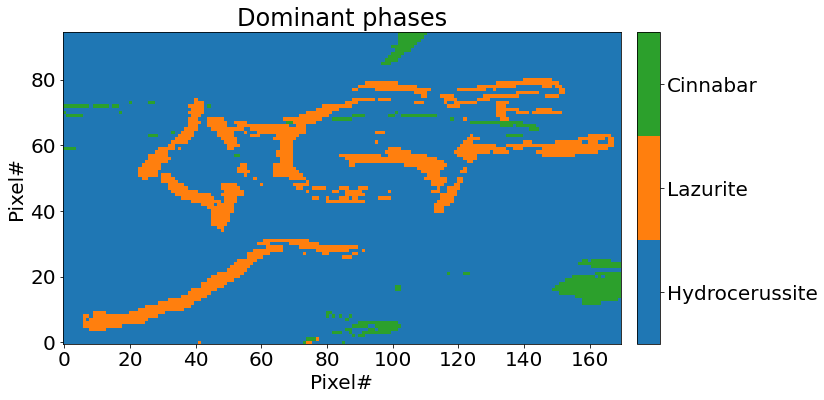

In [16]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(phases_primary) + 0.5, 1), len(phases_primary))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen, interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(phases_primary)))
cbar.set_ticklabels([p.label for p in phases_primary])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

### Histogram of $a$

If $a$ is spead over too large area it means that fitting went wrong. Maybe we need to add phases.

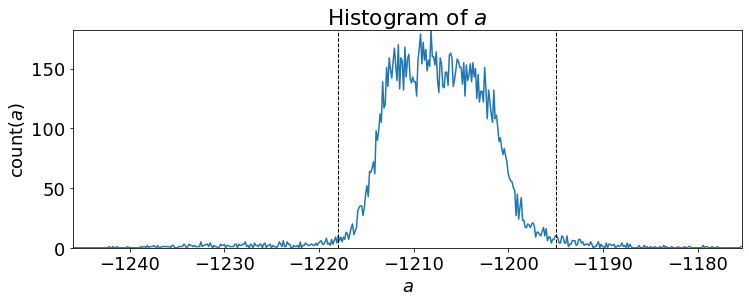

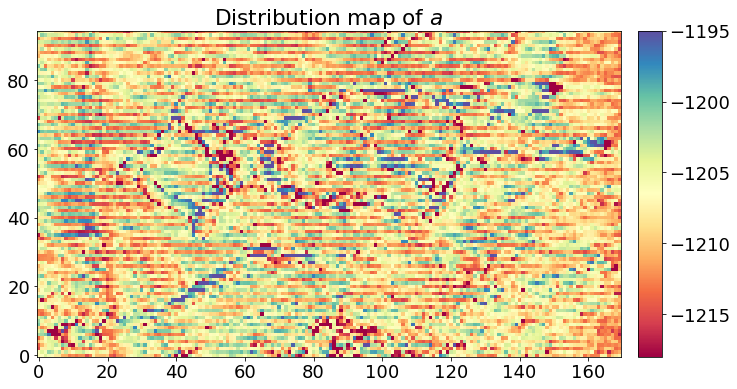

In [17]:
%matplotlib inline
rcParams['font.size'] = 18

opt = gm.opt()
a = opt[..., 0]
s = opt[..., 1]

### Set them for better representation of color map ###
vmin = -1218
vmax = -1195

h, b = histogram(a, bins = 512)

fig, ax = subplots(figsize = (12, 4))
ax.plot(b[:-1], h)
ax.set_xlim(b[0], b[-1])
#ax.set_xlim(-1230, -1180) # TO CHANGE HORIZONTAL SCALE: set these value, otherwise leave this line commented
ax.set_ylim(0, h.max())
ax.vlines(vmin, 0, h.max(), 'k', ls = '--', lw = 1)
ax.vlines(vmax, 0, h.max(), 'k', ls = '--', lw = 1)
ax.set_xlabel('$a$')
ax.set_ylabel(r'count($a$)')
ax.set_title(r'Histogram of $a$')
savefig(path_figures + f'histogram_a_ROI({vmin},{vmax}).png')

fig, ax = subplots(figsize = (12, 6))
ax.set_title('Distribution map of $a$')
im = ax.imshow(a, cmap = 'Spectral', interpolation = 'none', vmin = vmin, vmax = vmax)
colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
savefig(path_figures + f'distribution_map_a_ROI({vmin},{vmax}).png')

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $a, s$ dependence but it is weak.

Linear: [  -1.79597116 -219.93390074]
Cauchy: [ -0.90252648 857.86012077]
mean a,s: -1207.3345575986314 1948.4041480300689
most probable a,s: -1208.1677362854252 1948.263496458418


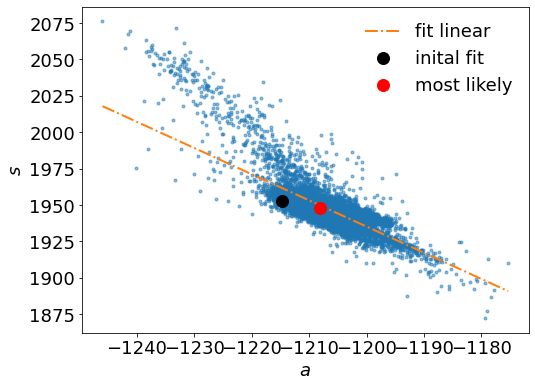

In [18]:
%matplotlib inline
rcParams['font.size'] = 18

opt, var = curve_fit(f_linear, a.flatten(), s.flatten())
res = least_squares(f_loss, x0 = opt, args = (a.flatten(), s.flatten()), loss = 'cauchy')
pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])
x = linspace(a.min(), a.max(), 10)
# linear_y = f_linear(a.flatten(), *opt)
# cauchy_y = f_linear(a.flatten(), *res['x'])

print('Linear:', opt)
print('Cauchy:', res['x'])
print('mean a,s:', a.mean(), s.mean())
print('most probable a,s:', pmax_a, pmax_s)

fig, ax = subplots(figsize = (8, 6))
ax.plot(a.flatten(), s.flatten(), '.', alpha = 0.5)
ax.plot(x, f_linear(x, *opt), '-.', lw = 2, label = 'fit linear')
#ax.plot(x, f_linear(x, *res['x']), '--', lw = 2, label = 'fit cauchy')
ax.plot(data.opt[0], data.opt[1], 'ko', ms = 12, label = 'inital fit')
ax.plot(pmax_a, pmax_s, 'ro', ms = 12, label = 'most likely')
ax.legend(frameon = False)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$s$')

### TO SET HORIZONTAL AND VERTICAL SCALE ###
# If you prefer automatic scale, you can leave this options commented.
#ax.set_xlim(-1250, -1180)
#ax.set_ylim(1850, 2000)

savefig(path_figures + 'fit_a_s.png')
show()

### Quantify phase presence

In [19]:
correction = data.rescaling**0.5
#correction = data.signal_background_ratio

criterion = overlap_area * correction

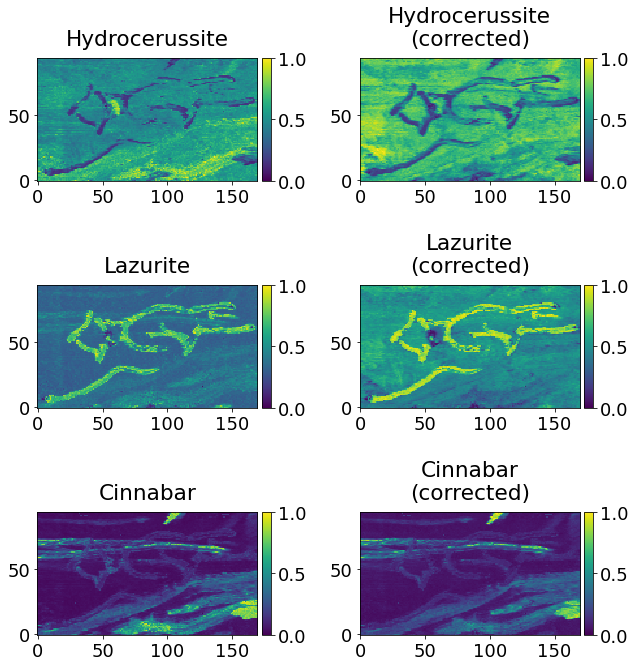

In [20]:
%matplotlib inline
rcParams['font.size'] = 18
position_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm.phases):
    if (len(gm.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:

            if (len(gm.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none')
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion[..., i] / criterion[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

# Select the phases for analysis
- phase_reference: the phase that will be used to take a reference calibration
- phase_analysis: the phase whose calibration will be analised

You need to choose phases among the primary ones.
You can also choose the two phases to be equal.

In [21]:
phase_reference = hydrocerussite
phase_analysis = hydrocerussite

### Calibration

In [22]:
%%time

phases_sel = [phase_reference, phase_analysis]
gm_sel = []
for i in [0, 1]:
    print(f'Calibrating on {phases_sel[i].label}...')
    gm_sel.append(
        GammaMap().from_data(data, phases_sel, sigma = sigma, min_theta = min_theta, max_theta = max_theta, 
                             min_intensity = min_intensity, first_n_peaks = first_n_peaks)
    )
    gm_sel[i] = gm_sel[i].search(phase_selected = i)
    print('Done.')

Calibrating on Hydrocerussite...
Using 8 CPUs
Done.
Calibrating on Hydrocerussite...
Using 8 CPUs
Done.
CPU times: user 15.7 s, sys: 3.23 s, total: 18.9 s
Wall time: 26.6 s


### Phase presence

In [23]:
presence_phases_sel = []
for i in [0, 1]:
    idx = gm.phases.index(phases_sel[i])
    presence_phases_sel.append(criterion[..., idx] / criterion[..., idx].max())
presence_phases_sel = array(presence_phases_sel)

# Analyse the selected phase in a given area

### Select area

Area: 36 * 24 = 864


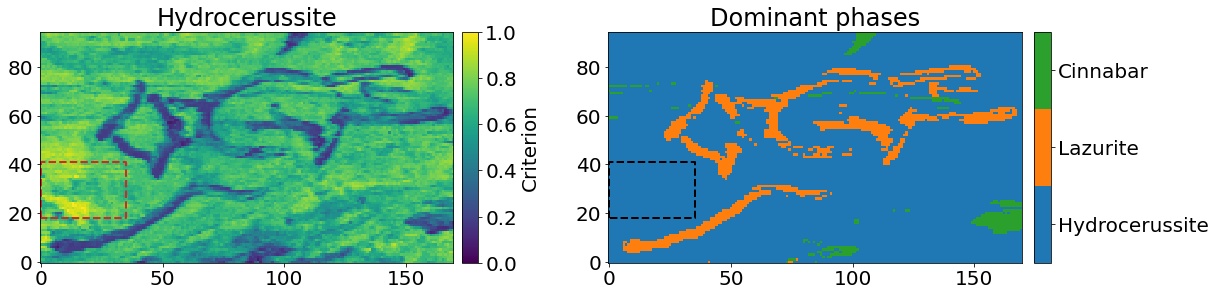

In [24]:
%matplotlib inline
rcParams['font.size'] = 20
position_colorbar = [1.02, 0, 0.04, 1]

# All scanned area
#x_min, x_max = 0, data.shape[1] - 1
#y_min, y_max = 0, data.shape[0] - 1

# Selected area
x_min, x_max = 0, 35
y_min, y_max = 18, 41

area_sel = (x_max - x_min + 1) * (y_max - y_min + 1)
print(f'Area: {x_max - x_min + 1} * {y_max - y_min + 1} = {area_sel}')

fig, axs = subplots(1, 2, figsize = (15, 5))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(presence_phases_sel[1, ...], interpolation = 'none', vmin = 0, vmax = 1)
settings_plot(im, ax, None, None, None, None, position_colorbar, 'Criterion')
ax.plot(
    [x_min, x_min, x_max, x_max, x_min],
    [y_min, y_max, y_max, y_min, y_min],
    ls = '--', c = 'tab:red', lw = 2
)
ax.set_title(phase_analysis.label)

ax = axs[1]
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen, interpolation = 'none')
ax.plot(
    [x_min, x_min, x_max, x_max, x_min],
    [y_min, y_max, y_max, y_min, y_min],
    ls = '--', c = 'black', lw = 2
)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')

savefig(f'{path_figures + phase_analysis.label}__selected_area.png', bbox_inches = 'tight', dpi = 200)
show()

### Select conditions

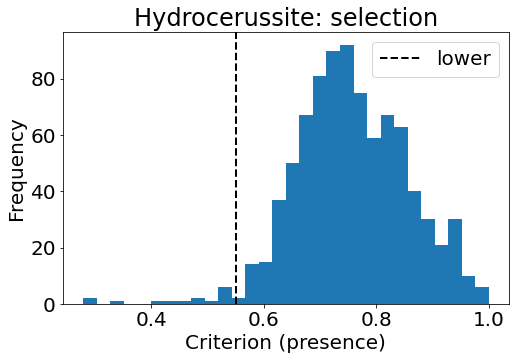

These thresholds select 849 pixels.


In [25]:
%matplotlib inline
rcParams['font.size'] = 20

threshold = {'low': 0.55, 'high': None} # Hydrocerussite
#threshold = {'low': 0.76, 'high': None} # Lazurite
#threshold = {'low': 0.2, 'high': None} # Cinnabar

indices_area = zeros(data.shape[:2], bool)
indices_good = zeros(data.shape[:2], bool)
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if ((x >= x_min) and (x <= x_max) and (y >= y_min) and (y <= y_max)):
            indices_area[y, x] = True
            if ( ((threshold['low'] is None) or (presence_phases_sel[1, y, x] >= threshold['low']))  and
                ((threshold['high'] is None) or (presence_phases_sel[1, y, x] <= threshold['high']))
            ):
                indices_good[y, x] = True

presence_service = presence_phases_sel[0, ...].copy()
presence_service[~indices_good] = None
y_ref, x_ref = unravel_index(nanargmax(presence_service), presence_service.shape)
del presence_service
opt_reference = gm_sel[0].get_pixel(x_ref, y_ref).opt.copy()
                
calibration_sel_a = gm_sel[1].opt()[..., 0].copy()
calibration_sel_s = gm_sel[1].opt()[..., 1].copy()
calibration_a_diff = calibration_sel_a - opt_reference[0]
calibration_s_diff = calibration_sel_s - opt_reference[1]

calibration_sel_a[~indices_good] = None
calibration_sel_s[~indices_good] = None
calibration_a_diff[~indices_good] = None
calibration_s_diff[~indices_good] = None

a_diff_max = nanmax(absolute(calibration_a_diff))
a_diff_min = - a_diff_max
s_diff_max = nanmax(absolute(calibration_s_diff))
s_diff_min = - s_diff_max

fig, ax = subplots(figsize = (8, 5))
ax.hist(presence_phases_sel[1, indices_area].flatten(), bins = 'sqrt') # 'sqrt' 'doane'
if (threshold['low'] is not None):
    ax.axvline(threshold['low'], c = 'black', ls = '--', lw = 2, label = 'lower')
if (threshold['high'] is not None):
    ax.axvline(threshold['high'], c = 'black', ls = '-', lw = 2, label = 'upper')
if (threshold['low'] is not None or threshold['high'] is not None):
    ax.legend(loc = 'upper right')
ax.set_xlabel('Criterion (presence)')
ax.set_ylabel('Frequency')
ax.set_title(f'{phase_analysis.label}: selection')

savefig(f'{path_figures + phase_analysis.label}__selection.png', bbox_inches = 'tight', dpi = 300)
show()
print(f'These thresholds select {indices_good.sum()} pixels.')

### Distribution of `a` in selected pixels

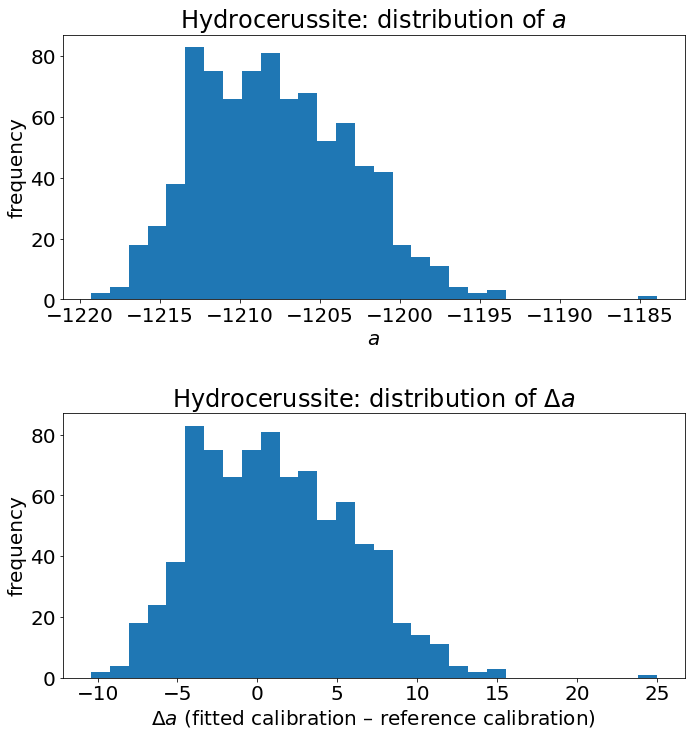

In [26]:
%matplotlib inline
rcParams['font.size'] = 20

fig, axs = subplots(2, 1, figsize = (10, 10))
fig.tight_layout(h_pad = 4)

ax = axs[0]
ax.hist(calibration_sel_a.flatten(), bins = 'sqrt') # 'sqrt' 'doane'
ax.set_xlabel(f'$a$')
ax.set_ylabel('frequency')
ax.set_title(f'{phase_analysis.label}: distribution of $a$')

ax = axs[1]
ax.hist(calibration_a_diff.flatten(), bins = 'sqrt') # 'sqrt' 'doane'
ax.set_xlabel(f'$\Delta a$ (fitted calibration – reference calibration)')
ax.set_ylabel('frequency')
ax.set_title(f'{phase_analysis.label}: distribution of $\Delta a$')

savefig(f'{path_figures + phase_analysis.label}__histogram_a_in_selection.png', bbox_inches = 'tight', dpi = 300)
show()

### Exploration of the area

/var/folders/t4/2fp3yd4127g0hx04c52d4fgm0000gn/T/ipykernel_70254/3791038800.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  cmap_seismic.set_bad(color = 'grey')


Reference pixel: (13, 24)


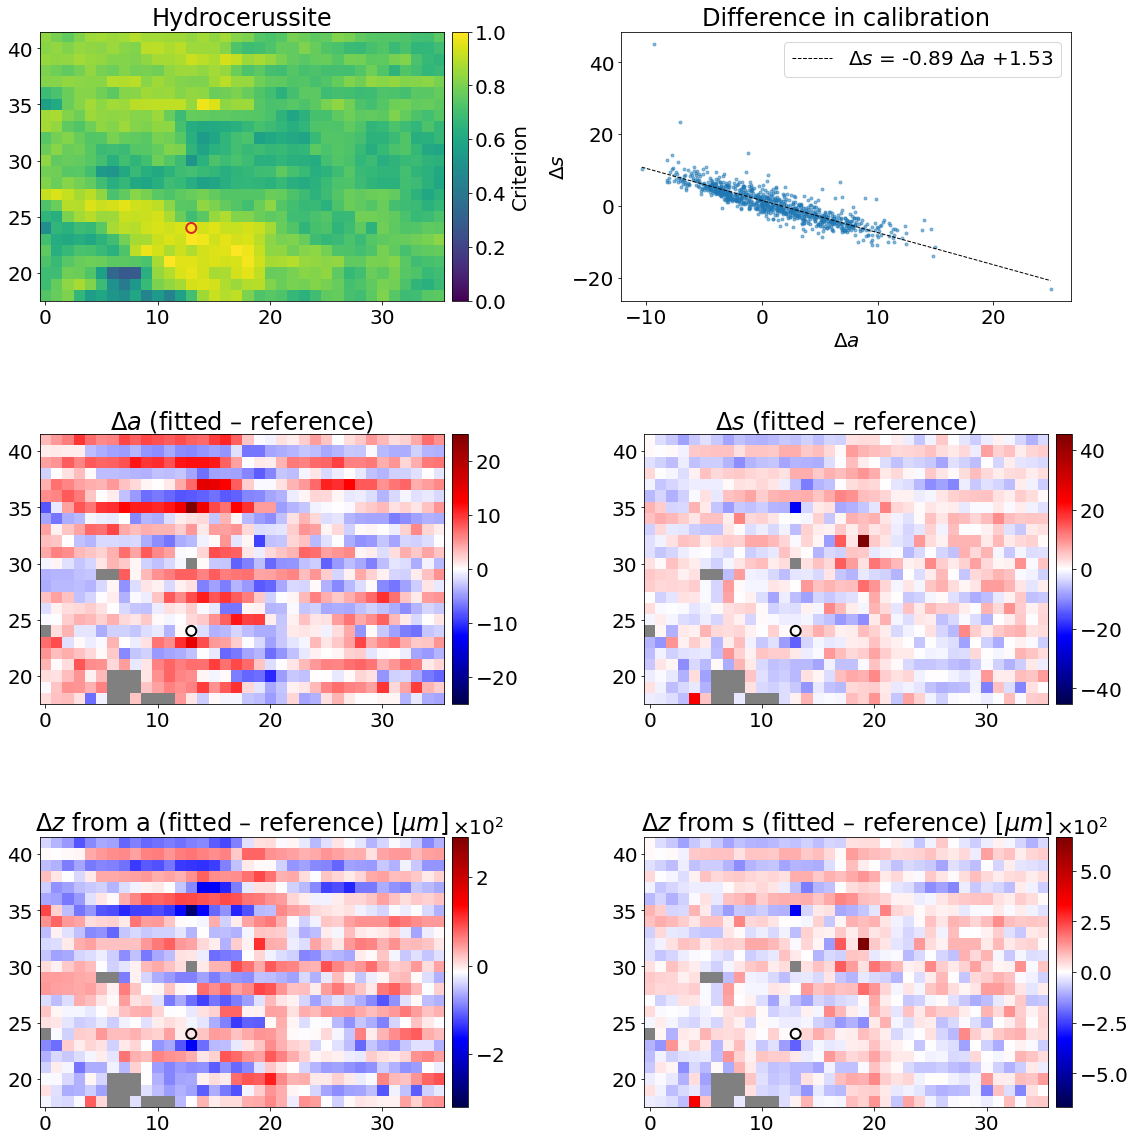

In [27]:
%matplotlib inline
rcParams['font.size'] = 20
position_colorbar = [1.02, 0, 0.04, 1]

cmap_seismic = get_cmap('seismic')#.copy()
cmap_seismic.set_bad(color = 'grey')

fig, axs = subplots(3, 2, figsize = (16, 16))
fig.tight_layout(w_pad = 5, h_pad = 5)

ax = axs[0, 0]
im = ax.imshow(presence_phases_sel[1], interpolation = 'none', vmin = 0, vmax = 1)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'tab:red', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'Criterion')
ax.set_title(phase_analysis.label)

ax = axs[0, 1]
lin_Da = linspace(nanmin(calibration_a_diff), nanmax(calibration_a_diff), 10)
fit_param, fit_var = curve_fit(f_linear, calibration_a_diff[indices_good], calibration_s_diff[indices_good])
ax.plot(calibration_a_diff.flatten(), calibration_s_diff.flatten(), '.', alpha = 0.5)
ax.plot(lin_Da, f_linear(lin_Da, *fit_param), ls = '--', lw = 1, c = 'black', label = f'$\Delta s$ = {fit_param[0]:.2f} $\Delta a$ {fit_param[1]:+.2f}')
ax.legend()
ax.set_xlabel(r'$\Delta a$')
ax.set_ylabel(r'$\Delta s$')
ax.set_title('Difference in calibration')

ax = axs[1, 0]
im = ax.imshow(calibration_a_diff, interpolation = 'none', vmin = a_diff_min, vmax = a_diff_max, cmap = cmap_seismic)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_title(f'$\Delta a$ (fitted – reference)')

ax = axs[1, 1]
im = ax.imshow(calibration_s_diff, interpolation = 'none', vmin = s_diff_min, vmax = s_diff_max, cmap = cmap_seismic)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_title(f'$\Delta s$ (fitted – reference)')

ax = axs[2, 0]
im = ax.imshow(Dz_from_Da(calibration_a_diff), interpolation = 'none', vmin = Dz_from_Da(a_diff_min), vmax = Dz_from_Da(a_diff_max), cmap = cmap_seismic)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_title(f'$\Delta z$ from a (fitted – reference) $[\mu m]$')

ax = axs[2, 1]
im = ax.imshow(Dz_from_Ds(calibration_s_diff), interpolation = 'none', vmin = Dz_from_Ds(s_diff_min), vmax = Dz_from_Ds(s_diff_max), cmap = cmap_seismic)
ax.scatter(x_ref, y_ref, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_title(f'$\Delta z$ from s (fitted – reference) $[\mu m]$')

print(f'Reference pixel: ({x_ref}, {y_ref})')
savefig(f'{path_figures + phase_analysis.label}__exploration_of_area.png', bbox_inches = 'tight', dpi = 300)
show()

### Check a point

/var/folders/t4/2fp3yd4127g0hx04c52d4fgm0000gn/T/ipykernel_70254/2972353975.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  cmap_seismic.set_bad(color = 'grey')


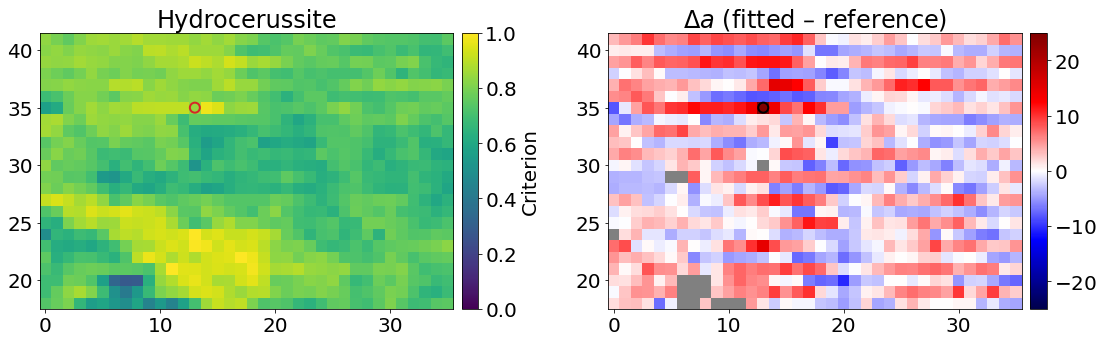

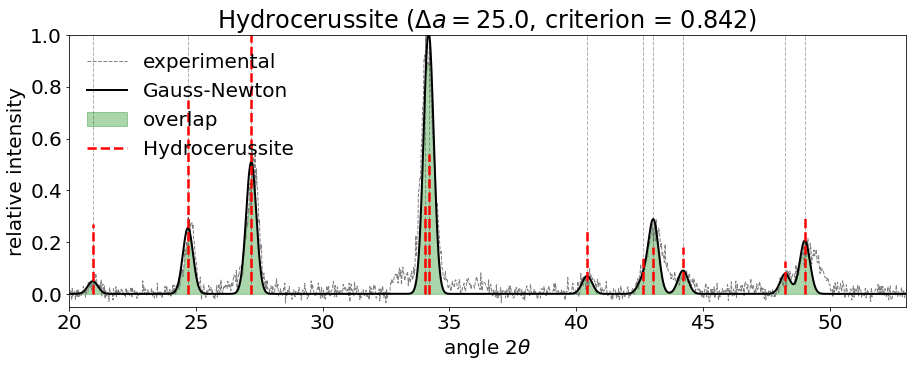

In [28]:
%matplotlib inline
rcParams['font.size'] = 20
position_colorbar = [1.02, 0, 0.04, 1]

x, y = 13, 35


cmap_seismic = get_cmap('seismic')#.copy()
cmap_seismic.set_bad(color = 'grey')

fig, axs = subplots(1, 2, figsize = (15, 8))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(presence_phases_sel[1, ...], interpolation = 'none', vmin = 0, vmax = 1)
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'tab:red', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, 'Criterion')
ax.set_title(phase_analysis.label)

ax = axs[1]
im = ax.imshow(calibration_a_diff, interpolation = 'none', vmin = a_diff_min, vmax = a_diff_max, cmap = cmap_seismic)
ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'black', facecolors = 'none')
settings_plot(im, ax, x_min, x_max, y_min, y_max, position_colorbar, powerlimits = (-2, 2))
ax.set_title(f'$\Delta a$ (fitted – reference)')

show()

fig, ax = subplots(figsize = (15, 5))
sca(ax)
gn = gm_sel[1].get_pixel(x, y)[1]
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '',
             min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gn.phase.plot(lw = 2.5, alpha = 1,
             min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label} ($\Delta a = {calibration_a_diff[y, x]:.1f}$, criterion = {presence_phases_sel[1, y, x]:.3f})')
legend(frameon = False, loc = 2)

savefig(f'{path_figures + phase_analysis.label}__pixel_{x}_{y}.png', bbox_inches = 'tight', dpi = 300)
show()